In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from evaluation.neuroprobe.config import ROOT_DIR, SAMPLING_RATE
from subject.braintreebank import BrainTreebankSubject
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from scipy.stats import pearsonr
from matplotlib.lines import Line2D
import torch
from model.BFModule import BFModule
import torch.nn as nn
import matplotlib.image as mpimg

SUBJECT_TRIAL_TO_MOVIE = {
    (1,0): 'fantastic-mr-fox.mp4',
    (1,1): 'the-martian.mp4',
    (1,2): 'thor-ragnarok.mp4',
    (2,0): 'venom.mp4',
    (2,1): 'spider-man-3-homecoming.mp4',
    (2,2): 'guardians-of-the-galaxy.mp4',
    (2,3): 'guardians-of-the-galaxy-2.mp4',
    (2,4): 'avengers-infinity-war.mp4',
    (2,5): 'black-panther.mp4',
    (2,6): 'aquaman.mp4',
    (3,0): 'cars-2.mp4',
    (3,1): 'lotr-1.mp4',
    (3,2): 'lotr-2.mp4',
    (4,0): 'shrek-the-third.mp4',
    (4,1): 'megamind.mp4',
    (4,2): 'incredibles.mp4',
    (5,0): 'fantastic-mr-fox.mp4',
    (6,0): 'megamind.mp4',
    (6,1): 'toy-story.mp4',
    (6,4): 'coraline.mp4',
    (7,0): 'cars-2.mp4',
    (7,1): 'megamind.mp4',
    (8,0): 'sesame-street-episode-3990.mp4',
    (9,0): 'ant-man.mp4',
    (10,0): 'cars-2.mp4',
    (10,1): 'spider-man-far-from-home.mp4',
}

CLIP_DIR = "/om2/data/public/braintreebank_movies_clip_preprocessed_2/"
MOVIES_DIR = "/om2/data/public/braintreebank_movies/"
REGR_DIR = "/om2/data/public/braintreebank_movies_clip_preprocessed_2/regr_results/"

In [3]:
def get_movie_data(movie):
    clip_features_path = os.path.join(CLIP_DIR, movie.replace('.mp4', '_clip_features.npy'))
    timestamps_path = os.path.join(CLIP_DIR, movie.replace('.mp4', '_timestamps.npy'))
    movie_path = os.path.join(MOVIES_DIR, movie)

    clip_features = np.load(clip_features_path)  # shape: (num_samples, feature_dim)
    timestamps = np.load(timestamps_path)
    return clip_features, timestamps, movie_path

def get_subject_trial_from_movie(movie):
    subject_trial_list = []
    for subject_trial, movie_name in SUBJECT_TRIAL_TO_MOVIE.items():
        if movie_name == movie:
            subject_trial_list.append(subject_trial)
    return subject_trial_list

In [4]:
movie = 'ant-man.mp4'
clip_features, timestamps, movie_path = get_movie_data(movie)
subject_trial_list = get_subject_trial_from_movie(movie)
subject_trial_list

[(9, 0)]

In [ ]:
for subject_id, trial_id in subject_trial_list:

    subject = BrainTreebankSubject(subject_id, cache=False)
    electrode_locations = {electrode_label: subject.get_electrode_metadata(electrode_label)['DesikanKilliany'] for electrode_label in subject.get_electrode_labels()}
    unique_electrodes = list(electrode_locations.keys())

    save_dir = os.path.join(REGR_DIR, f"btbank{subject_id}", f"trial_{trial_id}")

    n_electrodes = len(unique_electrodes)
    n_cols = 4
    n_rows = (n_electrodes + n_cols - 1) // n_cols

    per_subplot_width = 6
    per_subplot_height = 6
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(per_subplot_width * n_cols, per_subplot_height * n_rows))
    axes = axes.flatten() if n_electrodes > 1 else [axes]

    electrode_scores = []
    for idx, electrode_label in enumerate(unique_electrodes):
        save_path = os.path.join(save_dir, f"{electrode_label}_test_correlation.png")
        corr_matrix_path = os.path.join(save_dir, f"{electrode_label}_test_correlation.npy")
        pval_matrix_path = os.path.join(save_dir, f"{electrode_label}_test_pval.npy")

        corr_matrix = np.load(corr_matrix_path)
        pval_matrix = np.load(pval_matrix_path)

        significant_mask = pval_matrix < 0.05
        # if np.any(significant_mask):
        #     mean_corr = np.mean(corr_matrix[significant_mask])
        # else:
        #     mean_corr = np.mean(corr_matrix)
        # electrode_scores.append((electrode_label, mean_corr))

        max_abs_corr = np.max(corr_matrix[significant_mask])
        electrode_scores.append((electrode_label, max_abs_corr))


        ax = axes[idx]
        img = mpimg.imread(save_path)
        ax.imshow(img)
        ax.axis('off')
        description = electrode_locations[electrode_label]
        ax.set_title(f"{electrode_label}\n{description}", fontsize=10)

    for j in range(idx+1, len(axes)):
        axes[j].axis('off')

    plt.title(f"btbank{subject_id}_{trial_id}")
    plt.tight_layout()
    plt.show()

    electrode_scores.sort(key=lambda x: x[1], reverse=True)

    print("Top electrodes by correlation:")
    for rank, (electrode_label, mean_corr) in enumerate(electrode_scores[:10], 1):
        print(f"{rank}. {electrode_label}: mean_corr={mean_corr:.3f}")

    # Optionally, select the best electrode(s) for further analysis/plotting
    best_electrodes = [electrode_scores[0][0]] if electrode_scores else []

In [5]:
def output_correlations(movie):
    subject_trial_list = get_subject_trial_from_movie(movie)

    for subject_id, trial_id in subject_trial_list:

        subject = BrainTreebankSubject(subject_id, cache=False)
        electrode_locations = {electrode_label: subject.get_electrode_metadata(electrode_label)['DesikanKilliany'] for electrode_label in subject.get_electrode_labels()}
        unique_electrodes = list(electrode_locations.keys())

        save_dir = os.path.join(REGR_DIR, f"btbank{subject_id}", f"trial_{trial_id}")

        n_electrodes = len(unique_electrodes)
        n_cols = 4
        n_rows = (n_electrodes + n_cols - 1) // n_cols

        per_subplot_width = 6
        per_subplot_height = 6
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(per_subplot_width * n_cols, per_subplot_height * n_rows))
        axes = axes.flatten() if n_electrodes > 1 else [axes]

        electrode_scores = []
        for idx, electrode_label in enumerate(unique_electrodes):
            save_path = os.path.join(save_dir, f"{electrode_label}_test_correlation.png")
            corr_matrix_path = os.path.join(save_dir, f"{electrode_label}_test_correlation.npy")
            pval_matrix_path = os.path.join(save_dir, f"{electrode_label}_test_pval.npy")

            corr_matrix = np.load(corr_matrix_path)
            pval_matrix = np.load(pval_matrix_path)

            significant_mask = pval_matrix < 0.05
            # if np.any(significant_mask):
            #     mean_corr = np.mean(corr_matrix[significant_mask])
            # else:
            #     mean_corr = np.mean(corr_matrix)
            # electrode_scores.append((electrode_label, mean_corr))

            max_abs_corr = np.max(corr_matrix[significant_mask])
            electrode_scores.append((electrode_label, max_abs_corr))


            ax = axes[idx]
            img = mpimg.imread(save_path)
            ax.imshow(img)
            ax.axis('off')
            description = electrode_locations[electrode_label]
            ax.set_title(f"{electrode_label}\n{description}", fontsize=10)

        for j in range(idx+1, len(axes)):
            axes[j].axis('off')

        plt.title(f"btbank{subject_id}_{trial_id}")
        plt.tight_layout()
        plt.show()

        electrode_scores.sort(key=lambda x: x[1], reverse=True)

        print("Top electrodes by correlation:")
        for rank, (electrode_label, mean_corr) in enumerate(electrode_scores[:10], 1):
            print(f"{rank}. {electrode_label}: mean_corr={mean_corr:.3f}")

        # Optionally, select the best electrode(s) for further analysis/plotting
        best_electrodes = [electrode_scores[0][0]] if electrode_scores else []

def output_electrode_heatmap(subject_id, trial_id, electrode_label):
    save_dir = os.path.join(REGR_DIR, f"btbank{subject_id}", f"trial_{trial_id}")
    save_path = os.path.join(save_dir, f"{electrode_label}_test_correlation.png")
    img = mpimg.imread(save_path)
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

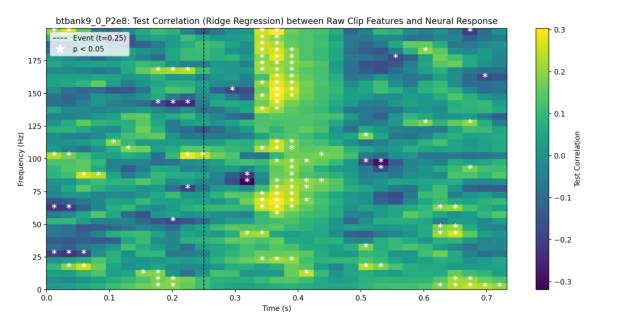

In [6]:
output_electrode_heatmap(9,0,'P2e8')

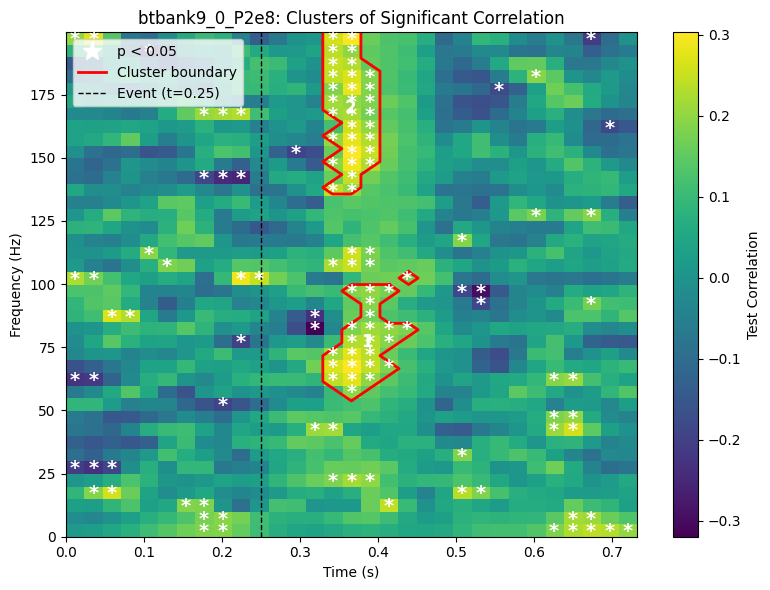

{'cluster_stats': [{'cluster_idx': 12,
   'mass': 5.183927719975457,
   'avg_corr': 0.2159969883323107,
   'avg_pval': 0.02100373106574639,
   'size': 24},
  {'cluster_idx': 27,
   'mass': 7.188666382605394,
   'avg_corr': 0.2318924639550127,
   'avg_pval': 0.013505455475644879,
   'size': 31}],
 'singular_pval': 0.017254593270695635,
 'n_clusters': 2}

In [7]:
from scipy.ndimage import label, find_objects, binary_dilation
from skimage.measure import find_contours
from matplotlib.lines import Line2D
import torch

def analyze_electrode_clusters(subject_id, trial_id, electrode_label, pval_threshold=0.05, plot=True):
    # Use the provided frequency and time bins
    freq_bins = torch.tensor([
        0.0000,   5.1200,  10.2400,  15.3600,  20.4800,  25.6000,  30.7200,
        35.8400,  40.9600,  46.0800,  51.2000,  56.3200,  61.4400,  66.5600,
        71.6800,  76.8000,  81.9200,  87.0400,  92.1600,  97.2800, 102.4000,
        107.5200, 112.6400, 117.7600, 122.8800, 128.0000, 133.1200, 138.2400,
        143.3600, 148.4800, 153.6000, 158.7200, 163.8400, 168.9600, 174.0800,
        179.2000, 184.3200, 189.4400, 194.5600, 199.6800
    ])
    time_bins = torch.tensor([
        0.0000, 0.0244, 0.0488, 0.0732, 0.0977, 0.1221, 0.1465, 0.1709, 0.1953,
        0.2197, 0.2441, 0.2686, 0.2930, 0.3174, 0.3418, 0.3662, 0.3906, 0.4150,
        0.4395, 0.4639, 0.4883, 0.5127, 0.5371, 0.5615, 0.5859, 0.6104, 0.6348,
        0.6592, 0.6836, 0.7080, 0.7324
    ])

    save_dir = os.path.join(REGR_DIR, f"btbank{subject_id}", f"trial_{trial_id}")
    corr_path = os.path.join(save_dir, f"{electrode_label}_test_correlation.npy")
    pval_path = os.path.join(save_dir, f"{electrode_label}_test_pval.npy")
    if not (os.path.exists(corr_path) and os.path.exists(pval_path)):
        print(f"Missing files for {electrode_label}")
        return None

    corr = np.load(corr_path)
    pval = np.load(pval_path)
    sig_mask = pval < pval_threshold

    # Label clusters (connectivity=2: 8-connected)
    structure = np.ones((3,3), dtype=bool)
    labeled, n_clusters = label(sig_mask, structure=structure)

    # Only keep clusters above a minimum size threshold
    min_cluster_size = 16  # e.g., must be at least 2x2 or larger; adjust as needed

    cluster_stats = []
    cluster_pvals = []
    cluster_masks = []
    for cluster_idx in range(1, n_clusters+1):
        cluster_mask = (labeled == cluster_idx)
        cluster_size = np.sum(cluster_mask)
        if cluster_size < min_cluster_size:
            continue  # skip small clusters (just a box wide)
        cluster_mass = np.sum(np.abs(corr[cluster_mask]))
        avg_corr = np.mean(corr[cluster_mask])
        avg_pval = np.mean(pval[cluster_mask])
        cluster_stats.append({
            'cluster_idx': cluster_idx,
            'mass': cluster_mass,
            'avg_corr': avg_corr,
            'avg_pval': avg_pval,
            'size': cluster_size
        })
        cluster_pvals.append(avg_pval)
        cluster_masks.append(cluster_mask)

    n_clusters = len(cluster_stats)

    singular_pval = np.mean(cluster_pvals) if cluster_pvals else np.nan

    if plot:
        # Plot correlation heatmap with cluster boundaries and asterisks for significant points
        fig, ax = plt.subplots(figsize=(8, 6))
        # Set extent to match the frequency and time bins
        extent = [
            time_bins[0].item(), time_bins[-1].item(),
            freq_bins[0].item(), freq_bins[-1].item()
        ]
        im = ax.imshow(
            corr,
            aspect='auto',
            origin='lower',
            cmap='viridis',
            extent=extent
        )
        plt.colorbar(im, ax=ax, label='Test Correlation')
        ax.set_title(f"btbank{subject_id}_{trial_id}_{electrode_label}: Clusters of Significant Correlation")
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Frequency (Hz)')

        # Overlay cluster boundaries (only for large clusters)
        for cluster_mask in cluster_masks:
            contours = find_contours(cluster_mask.astype(float), 0.5)
            for contour in contours:
                # Convert pixel coordinates to bin coordinates
                # contour[:, 0] is y (freq), contour[:, 1] is x (time)
                # Map to frequency and time using bin centers
                y_idx = contour[:, 0]
                x_idx = contour[:, 1]
                # Clamp indices to valid range
                y_idx = np.clip(y_idx, 0, len(freq_bins)-1)
                x_idx = np.clip(x_idx, 0, len(time_bins)-1)
                freq_vals = np.interp(y_idx, np.arange(len(freq_bins)), freq_bins.numpy())
                time_vals = np.interp(x_idx, np.arange(len(time_bins)), time_bins.numpy())
                ax.plot(time_vals, freq_vals, color='red', linewidth=2)

        # Optionally, mark cluster centers
        for i, cluster_mask in enumerate(cluster_masks):
            yx = np.argwhere(cluster_mask)
            if yx.size > 0:
                y_mean, x_mean = yx.mean(axis=0)
                # Map to bin values
                y_mean = np.clip(y_mean, 0, len(freq_bins)-1)
                x_mean = np.clip(x_mean, 0, len(time_bins)-1)
                freq_val = np.interp(y_mean, np.arange(len(freq_bins)), freq_bins.numpy())
                time_val = np.interp(x_mean, np.arange(len(time_bins)), time_bins.numpy())
                ax.text(time_val, freq_val, f"{i+1}", color='white', fontsize=12, ha='center', va='center', fontweight='bold')

        # Overlay asterisks for all significant points (p < threshold)
        star_y, star_x = np.where(sig_mask)
        # Compute bin centers for time and frequency
        time_edges = np.linspace(time_bins[0].item(), time_bins[-1].item(), len(time_bins) + 1)
        freq_edges = np.linspace(freq_bins[0].item(), freq_bins[-1].item(), len(freq_bins) + 1)
        time_centers = (time_edges[:-1] + time_edges[1:]) / 2
        freq_centers = (freq_edges[:-1] + freq_edges[1:]) / 2 - 0.5
        for y, x in zip(star_y, star_x):
            # Use bin centers for better centering of stars
            freq_val = freq_centers[y] if y < len(freq_centers) else freq_centers[-1]
            time_val = time_centers[x] if x < len(time_centers) else time_centers[-1]
            ax.text(time_val, freq_val, '*', color='white', fontsize=14, ha='center', va='center', fontweight='bold')

        # Add vertical event line at t=0.25
        event_time = 0.25
        event_line = ax.axvline(event_time, color='black', linestyle='--', linewidth=1, label='Event (t=0.25)')

        # Add legend for asterisk, cluster boundary, and event line
        asterisk_handle = Line2D([0], [0], marker='*', color='w', linestyle='None', markersize=14, markerfacecolor='w', label=f'p < {pval_threshold}')
        boundary_handle = Line2D([0], [0], color='red', linewidth=2, label='Cluster boundary')
        event_handle = Line2D([0], [0], color='black', linestyle='--', linewidth=1, label='Event (t=0.25)')
        ax.legend(handles=[asterisk_handle, boundary_handle, event_handle], loc='upper left', frameon=True)

        plt.tight_layout()
        plt.show()

    return {
        'cluster_stats': cluster_stats,
        'singular_pval': singular_pval,
        'n_clusters': n_clusters
    }

analyze_electrode_clusters(9, 0, 'P2e8')





=== btbank9 trial 0 ===

--- Top 1: Electrode T1b3 ---
  Max cluster correlation: 0.28032283154478266
  Description: ctx-lh-superiortemporal


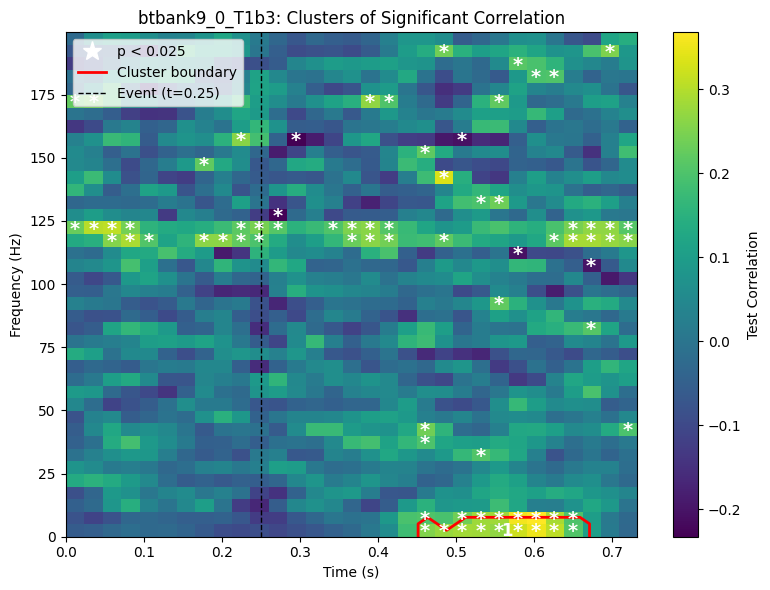


--- Top 2: Electrode T1d9 ---
  Max cluster correlation: 0.26354592389090215
  Description: ctx-lh-supramarginal


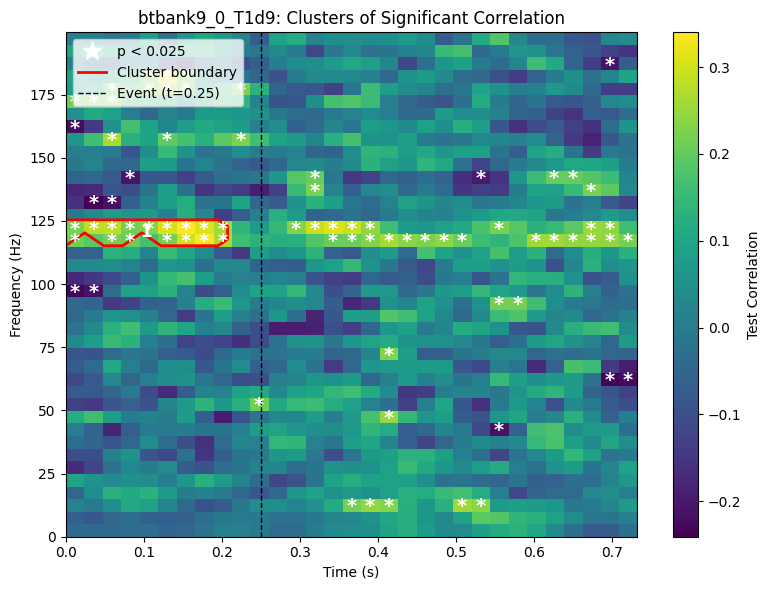


--- Top 3: Electrode P2d6 ---
  Max cluster correlation: 0.2624533637863392
  Description: ctx-lh-supramarginal


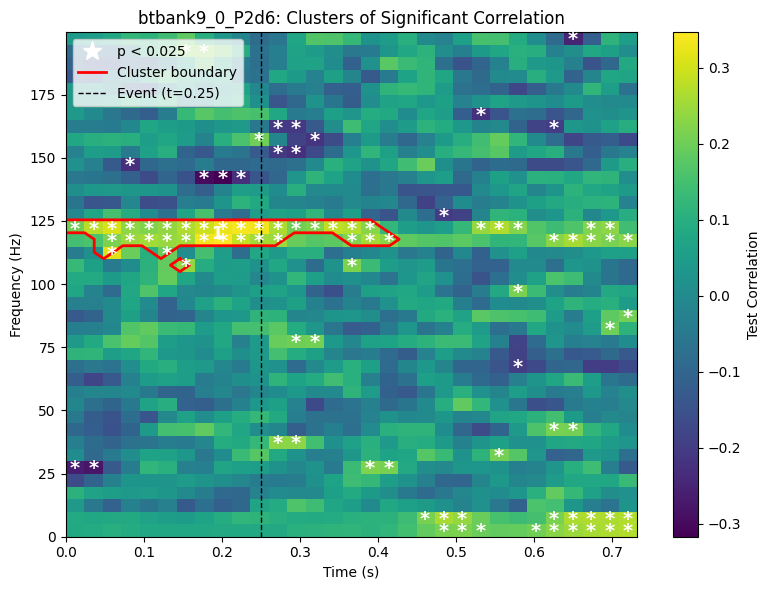


--- Top 4: Electrode T1b6 ---
  Max cluster correlation: 0.26099477933657544
  Description: ctx-lh-middletemporal


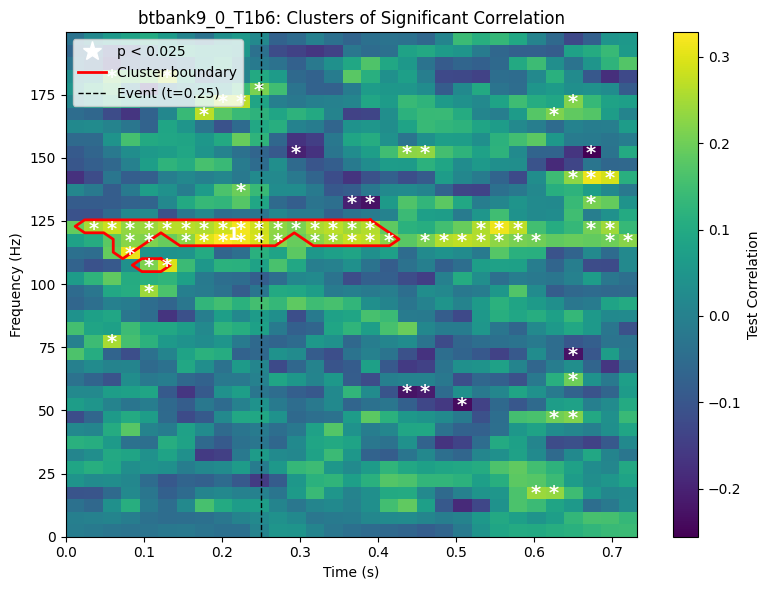


--- Top 5: Electrode T1d12 ---
  Max cluster correlation: 0.2579505108280828
  Description: ctx-lh-supramarginal


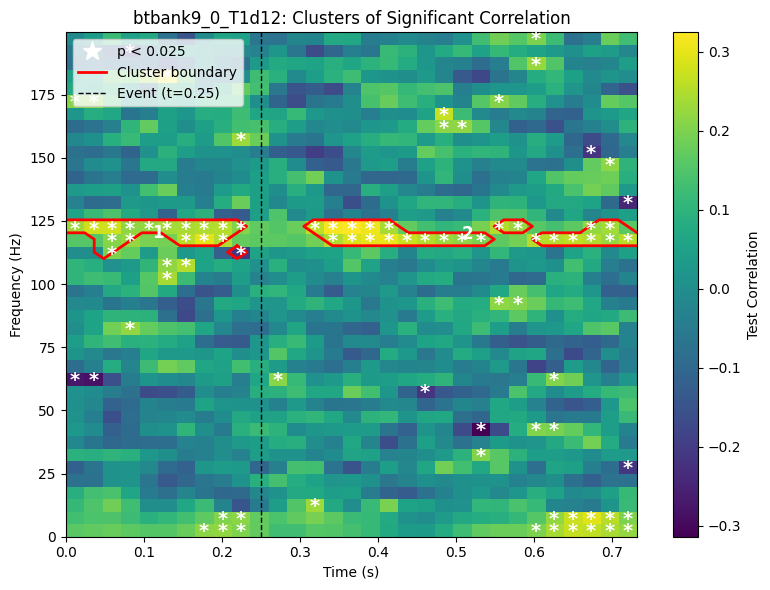

In [8]:
def analyze_top5_electrodes_per_trial(movie, pval_threshold=0.025):

    subject_trial_list = get_subject_trial_from_movie(movie)

    for subject_id, trial_id in subject_trial_list:

        subject = BrainTreebankSubject(subject_id, cache=False)
        electrode_locations = {electrode_label: subject.get_electrode_metadata(electrode_label)['DesikanKilliany'] for electrode_label in subject.get_electrode_labels()}
        unique_electrodes = list(electrode_locations.keys())

        print(f"\n=== btbank{subject_id} trial {trial_id} ===")
        cluster_sizes = []

        for electrode in unique_electrodes:
            result = analyze_electrode_clusters(subject_id, trial_id, electrode, pval_threshold=pval_threshold, plot=False)
            n_clusters = result.get('n_clusters', 0)
            max_corr = 0
            if n_clusters > 0 and 'cluster_stats' in result:
                max_corr = max([abs(c['avg_corr']) for c in result['cluster_stats']])
            cluster_corrs = (electrode, max_corr, result)
            cluster_corr_list = locals().setdefault('cluster_corr_list', [])
            cluster_corr_list.append(cluster_corrs)
        cluster_corr_list.sort(key=lambda x: x[1], reverse=True)
        top5 = cluster_corr_list[:5]
        for idx, (electrode, max_corr, result) in enumerate(top5, 1):
            print(f"\n--- Top {idx}: Electrode {electrode} ---")
            print(f"  Max cluster correlation: {max_corr}")
            print(f"  Description: {electrode_locations[electrode]}")
            analyze_electrode_clusters(subject_id, trial_id, electrode, pval_threshold=pval_threshold)



analyze_top5_electrodes_per_trial('ant-man.mp4')

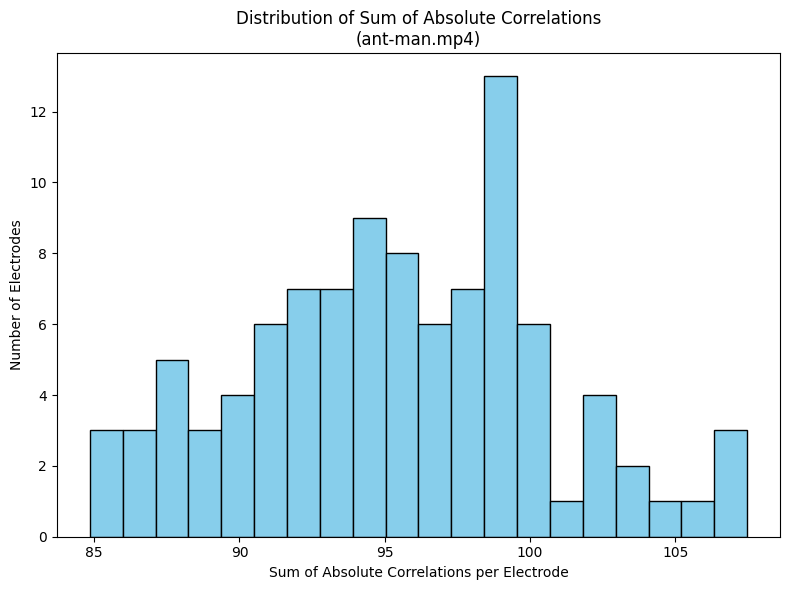

[('btbank9_t0_P1C14', 107.46925300174163),
 ('btbank9_t0_P2e5', 107.14877524993818),
 ('btbank9_t0_P2e4', 106.65487607901994),
 ('btbank9_t0_P2e8', 105.40922455098024),
 ('btbank9_t0_P2d6', 104.49296685610554)]

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sum_abs_corr_distribution(movie, pval_threshold=0.025):
    subject_trial_list = get_subject_trial_from_movie(movie)
    sum_abs_corrs = []
    electrode_labels = []

    for subject_id, trial_id in subject_trial_list:
        subject = BrainTreebankSubject(subject_id, cache=False)
        electrode_locations = {electrode_label: subject.get_electrode_metadata(electrode_label)['DesikanKilliany'] for electrode_label in subject.get_electrode_labels()}
        unique_electrodes = list(electrode_locations.keys())

        for electrode in unique_electrodes:
            save_dir = os.path.join(REGR_DIR, f"btbank{subject_id}", f"trial_{trial_id}")
            corr_matrix_path = os.path.join(save_dir, f"{electrode}_test_correlation.npy")
            corr_matrix = np.load(corr_matrix_path)

            if corr_matrix is not None:
                sum_abs = np.sum(np.abs(corr_matrix))
            else:
                sum_abs = 0
            sum_abs_corrs.append(sum_abs)
            electrode_labels.append(f"btbank{subject_id}_t{trial_id}_{electrode}")

    # Get top 5 electrodes with highest sum_abs_corrs
    top5_indices = np.argsort(sum_abs_corrs)[-5:][::-1]
    top5_electrodes = [(electrode_labels[i], sum_abs_corrs[i]) for i in top5_indices]

    plt.figure(figsize=(8,6))
    plt.hist(sum_abs_corrs, bins=20, color='skyblue', edgecolor='black')
    plt.xlabel('Sum of Absolute Correlations per Electrode')
    plt.ylabel('Number of Electrodes')
    plt.title(f'Distribution of Sum of Absolute Correlations\n({movie})')
    plt.tight_layout()
    plt.show()

    return top5_electrodes

plot_sum_abs_corr_distribution('ant-man.mp4')


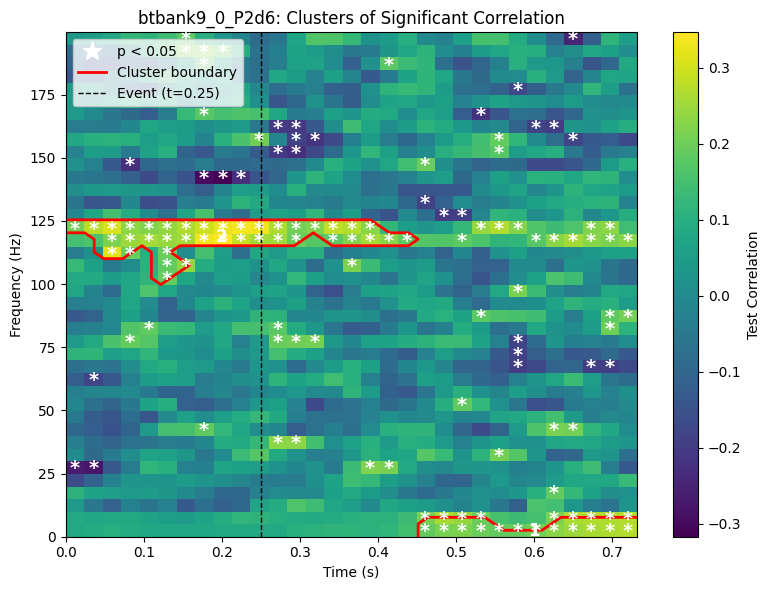

{'cluster_stats': [{'cluster_idx': 1,
   'mass': 4.850082191948101,
   'avg_corr': 0.2309562948546715,
   'avg_pval': 0.012612858756153625,
   'size': 21},
  {'cluster_idx': 18,
   'mass': 9.784181626139933,
   'avg_corr': 0.25087645195230596,
   'avg_pval': 0.009960826640410042,
   'size': 39}],
 'singular_pval': 0.011286842698281833,
 'n_clusters': 2}

In [10]:
analyze_electrode_clusters(9, 0, 'P2d6')

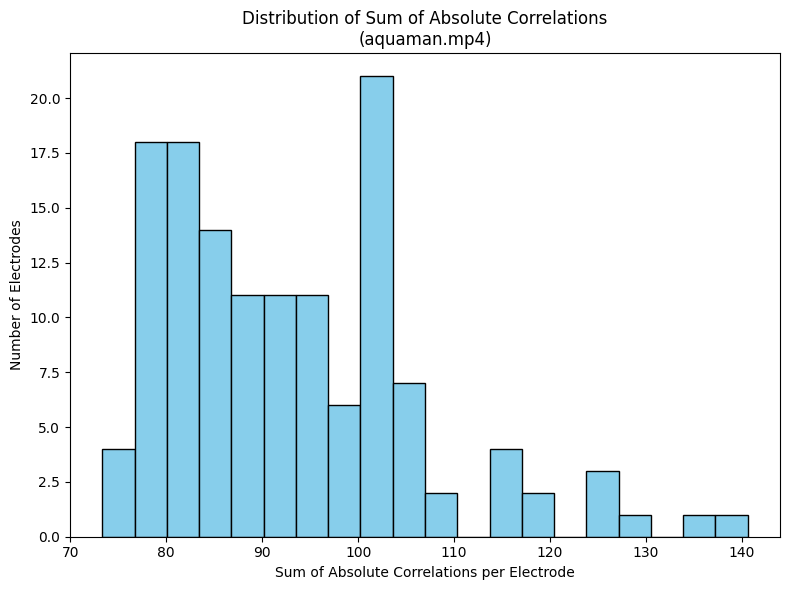

[('btbank2_t6_LT3a2', 140.60108396481252),
 ('btbank2_t6_LT3a1', 135.26551251979186),
 ('btbank2_t6_LT3a3', 130.16730644235773),
 ('btbank2_t6_LT2aA14', 125.49667212861647),
 ('btbank2_t6_LT3a7', 124.98348484072233)]

In [11]:
plot_sum_abs_corr_distribution('aquaman.mp4')

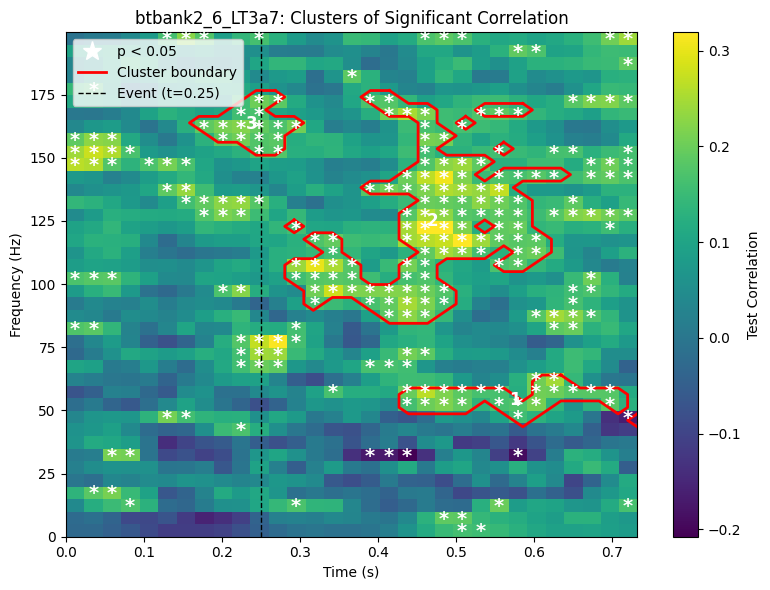

{'cluster_stats': [{'cluster_idx': 11,
   'mass': 4.427220672197492,
   'avg_corr': 0.17831195980388626,
   'avg_pval': 0.02054356423974598,
   'size': 23},
  {'cluster_idx': 17,
   'mass': 21.03446577913142,
   'avg_corr': 0.20622025273658254,
   'avg_pval': 0.016654876077901684,
   'size': 102},
  {'cluster_idx': 24,
   'mass': 3.0109232473652923,
   'avg_corr': 0.18818270296033077,
   'avg_pval': 0.020496829125991278,
   'size': 16}],
 'singular_pval': 0.01923175648121298,
 'n_clusters': 3}

In [12]:
analyze_electrode_clusters(2, 6, 'LT3a7')

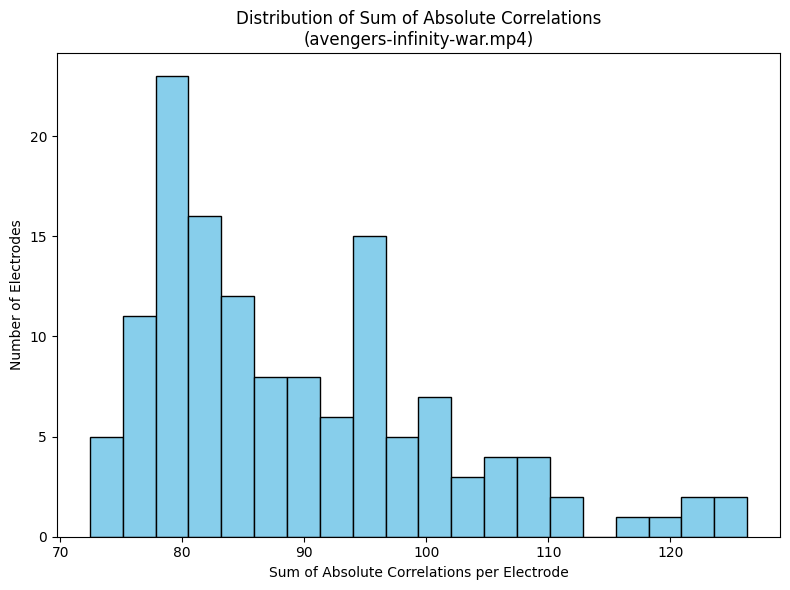

[('btbank2_t4_LT1bIb10', 126.29828843283542),
 ('btbank2_t4_LT3a10', 125.45425255888283),
 ('btbank2_t4_LT3d8', 122.05233756426901),
 ('btbank2_t4_LT3a9', 120.93953979402622),
 ('btbank2_t4_LT3a2', 118.37823580259912)]

In [13]:
plot_sum_abs_corr_distribution('avengers-infinity-war.mp4')

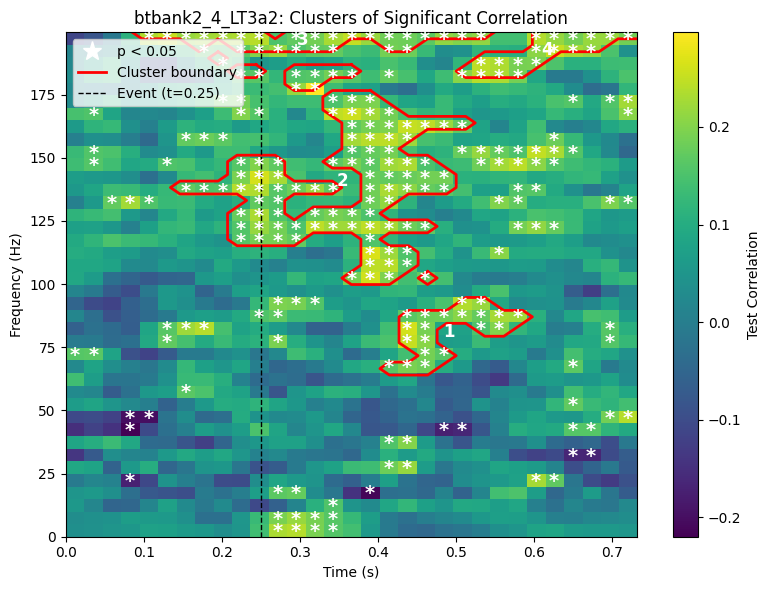

{'cluster_stats': [{'cluster_idx': 14,
   'mass': 3.964877242294531,
   'avg_corr': 0.19824386211472655,
   'avg_pval': 0.015938817679254917,
   'size': 20},
  {'cluster_idx': 21,
   'mass': 18.63177447989866,
   'avg_corr': 0.1961239418936701,
   'avg_pval': 0.0187048729607412,
   'size': 95},
  {'cluster_idx': 35,
   'mass': 5.927097144777908,
   'avg_corr': 0.19756990482593026,
   'avg_pval': 0.017181348131135785,
   'size': 30},
  {'cluster_idx': 37,
   'mass': 3.8924916183112526,
   'avg_corr': 0.21624953435062513,
   'avg_pval': 0.006830863333308754,
   'size': 18}],
 'singular_pval': 0.014663975526110163,
 'n_clusters': 4}

In [14]:
analyze_electrode_clusters(2, 4, 'LT3a2')

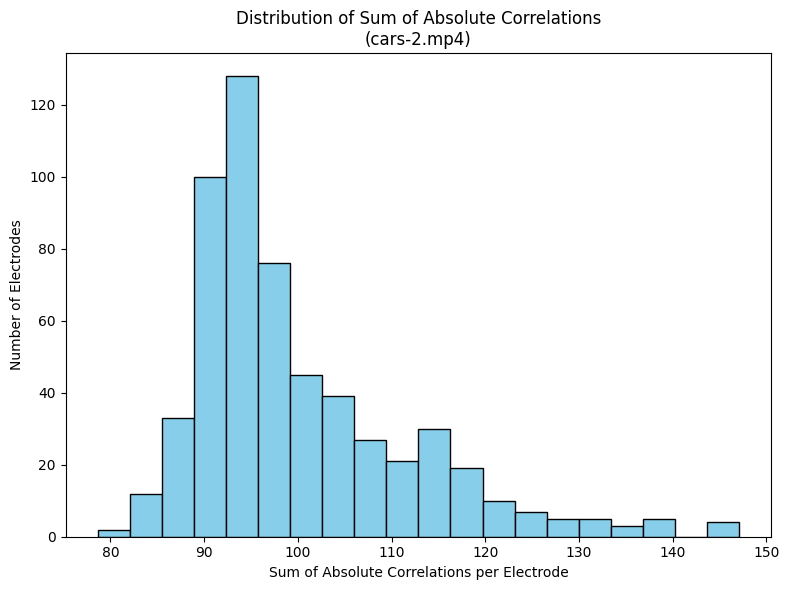

[('btbank10_t0_T1cIf12', 147.10768044672906),
 ('btbank10_t0_T2aA14', 146.84879136927373),
 ('btbank10_t0_T2aA13', 144.26726108419746),
 ('btbank10_t0_T2bH16', 144.26403786623732),
 ('btbank10_t0_T1aIa9', 140.21243868081015)]

In [15]:
plot_sum_abs_corr_distribution('cars-2.mp4')

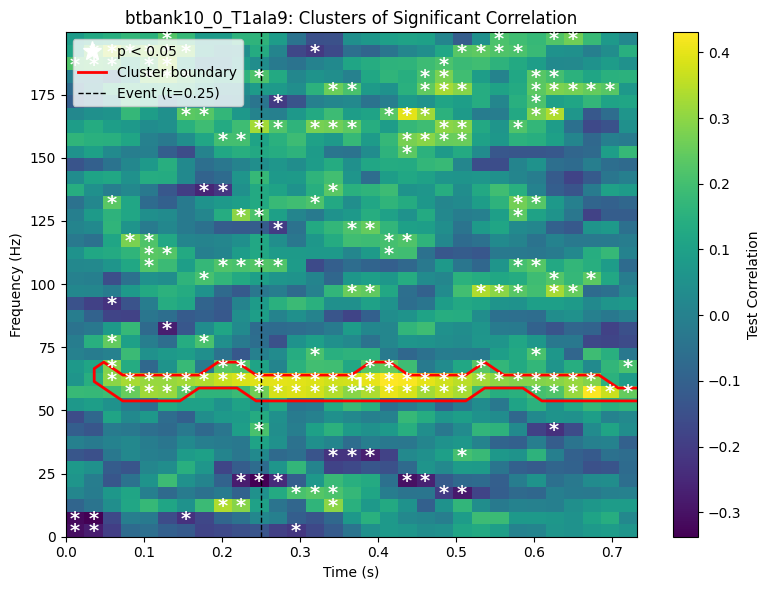

{'cluster_stats': [{'cluster_idx': 11,
   'mass': 18.000691491088514,
   'avg_corr': 0.327285299837973,
   'avg_pval': 0.0054300045319800915,
   'size': 55}],
 'singular_pval': 0.0054300045319800915,
 'n_clusters': 1}

In [16]:
analyze_electrode_clusters(10,0, 'T1aIa9')

In [17]:
# map the electrodes on the brain
import json
import glob
import random
from evaluation.neuroprobe.config import *
from matplotlib.colors import Normalize

matlab_xlim = (-108.0278, 108.0278)
matlab_ylim = (-72.9774, 72.9774)

base_path = os.path.join(ROOT_DIR, 'localization')
left_hem_file_name = 'left_hem_clean.png'
right_hem_file_name = 'right_hem_clean.png'
coords_file_name = 'elec_coords_full.csv'
correlations_file = 'lag_correlation.json'

left_hem_img = plt.imread(os.path.join(base_path, left_hem_file_name))
right_hem_img = plt.imread(os.path.join(base_path, right_hem_file_name))
coords_df = pd.read_csv(os.path.join(base_path, coords_file_name))
split_elec_id = coords_df['ID'].str.split('-')
coords_df['Subject'] = [t[0] for t in split_elec_id]
coords_df['Electrode'] = [t[1] for t in split_elec_id]

# Scale Matlab electrode locations to Python format
def scale(x, s, d):
    return -(x - d) * s

x_scale = left_hem_img.shape[1] / (matlab_xlim[1] - matlab_xlim[0])
y_scale_l = left_hem_img.shape[0] / (matlab_ylim[1] - matlab_ylim[0])

y_scale_r = right_hem_img.shape[0] / (matlab_ylim[1] - matlab_ylim[0])

scaled_coords_df = coords_df.copy()

# scale left hemisphere coordinates
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 1, 'X'] = coords_df.loc[coords_df['Hemisphere'] == 1, 'X'].apply(lambda x: scale(x, x_scale, matlab_xlim[1]))
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 1, 'Y'] = coords_df.loc[coords_df['Hemisphere'] == 1, 'Y'].apply(lambda x: scale(x, y_scale_l, matlab_ylim[1]))

# scale right hemisphere coordinates
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 0, 'X'] = coords_df.loc[coords_df['Hemisphere'] == 0, 'X'].apply(lambda x: -scale(x, y_scale_r, matlab_xlim[0]))
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 0, 'Y'] = coords_df.loc[coords_df['Hemisphere'] == 0, 'Y'].apply(lambda x: scale(x, y_scale_r, matlab_ylim[1]))


In [18]:
print("Subjects in scaled_coords_df:", scaled_coords_df['Subject'].unique())
print("Electrodes in scaled_coords_df:", scaled_coords_df['Electrode'].unique())

Subjects in scaled_coords_df: ['sub_1' 'sub_2' 'sub_3' 'sub_5' 'sub_8' 'sub_9' 'sub_10' 'sub_6' 'sub_4'
 'sub_7']
Electrodes in scaled_coords_df: ['T2aA12' 'T2aA11' 'T2aA10' ... 'RF3aOFa1' 'RF1bCb12' 'RF1bCb11']


In [19]:
def plot_hemisphere_axis(electrodes, colors=None, ax=None, hemisphere="left", title=None, vmin=0, vmax=0.1):
    '''
    electrodes is a dict of format {<subject>: [<electrode>]}
    '''
    if colors is None: c = 'white'
    ax.set_aspect('equal')

    if hemisphere=="left":
        ax.imshow(left_hem_img)
    elif hemisphere=="right":
        ax.imshow(right_hem_img)
    
    ax.axis('off')
    assert hemisphere in ["left", "right"]
    hem_index = 1 if hemisphere=="left" else 0

    plot_title = f'{hemisphere} hemisphere'
    if title: plot_title += f' {title}'
   
    all_x, all_y, all_colors = [], [], []
    for s in electrodes:
        for e in electrodes[s]:
            x = list(scaled_coords_df[(scaled_coords_df.Subject == s) & (scaled_coords_df.Electrode == e) & (scaled_coords_df.Hemisphere==hem_index)]['X'])
            y = list(scaled_coords_df[(scaled_coords_df.Subject == s) & (scaled_coords_df.Electrode == e) & (scaled_coords_df.Hemisphere==hem_index)]['Y'])
            if (len(x) == 0 or len(y) == 0) and hemisphere == "left":
                print(f"Warning: No coordinates found for subject {s} and electrode {e} in {hemisphere} hemisphere")
            if len(x) == 0 or len(y) == 0:
                continue
            
            assert len(x) == len(y) == 1, f"For subject {s} and electrode {e}, x: {x}, y: {y}"

            all_x += x
            all_y += y
            all_colors += [colors[e]]
    print(all_colors)
    
    all_x = np.array(all_x)
    all_y = np.array(all_y)
    all_colors = np.array(all_colors)
    # Sort points by color value so lower values appear on top
    sort_idx = np.argsort(all_colors)[::-1]
    sc = ax.scatter(all_x[sort_idx], all_y[sort_idx], c=all_colors[sort_idx], vmin=vmin, vmax=vmax, s=100, edgecolors='black', cmap='viridis_r')
    
def plot_hemispheres_separately(electrodes, ax1, ax2, colors=None, vmin=0, vmax=0.1):
    plot_hemisphere_axis(electrodes, colors=colors, ax=ax1, hemisphere="right", vmin=vmin, vmax=vmax)
    plot_hemisphere_axis(electrodes, colors=colors, ax=ax2, hemisphere="left", vmin=vmin, vmax=vmax)

/tmp/ipykernel_14726/3137190763.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')
/tmp/ipykernel_14726/2853737120.py:42: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  sc = ax.scatter(all_x[sort_idx], all_y[sort_idx], c=all_colors[sort_idx], vmin=vmin, vmax=vmax, s=100, edgecolors='black', cmap='viridis_r')


{'T1cIf12': '#fde725', 'T2aA14': '#e7e419', 'T2aA13': '#21a585', 'T2bH16': '#21a585', 'T1aIa9': '#440154'}
{'sub_10': ['T1cIf12', 'T2aA14', 'T2aA13', 'T2bH16', 'T1aIa9']}
['#fde725', '#e7e419', '#21a585', '#21a585', '#440154']
[]


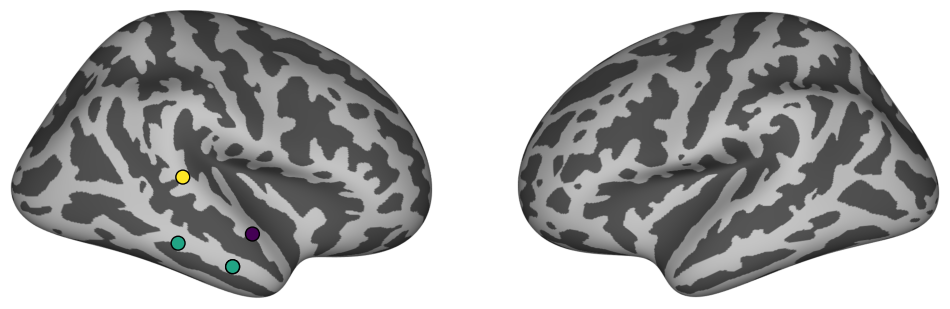

In [20]:

electrode_value_list = [('btbank10_t0_T1cIf12', 147.10768044672906),
 ('btbank10_t0_T2aA14', 146.84879136927373),
 ('btbank10_t0_T2aA13', 144.26726108419746),
 ('btbank10_t0_T2bH16', 144.26403786623732),
 ('btbank10_t0_T1aIa9', 140.21243868081015)]

# 1. Build a mapping from electrode label to value
colors = {}
for label, value in electrode_value_list:
    colors[label] = value


# 2. Normalize the values for colormap
values = np.array(list(colors.values()))
norm = Normalize(vmin=values.min(), vmax=values.max())

# 3. Prepare the electrodes dictionary for plotting
#    The plot_hemispheres_separately function expects a dict {subject: [electrode, ...]}
#    We'll extract subject from the electrode label (assuming format 'btbank<subject>_t<trial>_<electrode>')
import re
electrodes = {}
for label in colors:
    m = re.match(r'btbank(\d+)_t\d+_(.+)', label)
    if m:
        subject = m.group(1)
        electrode = m.group(2)
        key = f'sub_{subject}'
        if key not in electrodes:
            electrodes[key] = []
        electrodes[key].append(electrode)
    else:
        print(f"Warning: Could not parse label {label}")


import matplotlib

electrode_name_to_value = {}
for label, value in electrode_value_list:
    m = re.match(r'btbank\d+_t\d+_(.+)', label)
    if m:
        electrode = m.group(1)
        # Normalize value to 0-1 range for colormap
        normed = (value - values.min()) / (values.max() - values.min()) if values.max() > values.min() else 0.0
        # Use a colormap (e.g., viridis) to get RGBA, then convert to hex
        cmap = matplotlib.cm.get_cmap('viridis')
        rgba = cmap(normed)
        hex_color = matplotlib.colors.to_hex(rgba)
        electrode_name_to_value[electrode] = hex_color

print(electrode_name_to_value)
print(electrodes)

# 5. Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plot_hemispheres_separately(
    electrodes,
    axes[0],
    axes[1],
    colors=electrode_name_to_value,
    vmin=values.min(),
    vmax=values.max()
)
plt.show()
